## US Border Patrol Basic Analysis

CBP Website for reference:  
https://www.cbp.gov/newsroom/stats/southwest-land-border-encounters

### Important:
To get this file to work you must have the following libraries installed:
- pandas
- openpyxl
- seaborn  
  
You must also have the excel file "USBP SBO Encounters by Sector Citiz Group Demo FY13-FY21TD-FEB.xlsx" downloaded in the same folder as this notebook  
  
If you are unfamiliar with python here is a guide on pip installing:
- https://docs.python.org/3/installing/index.html  
  
### Inputs

In [15]:
PAST_YEARS = 3   # How many of the past years should be taken into account for the forecasting
GRAPH_YEARS = 5  # How many past years should be displayed on graphs

CATEGORY = "Demographic"
#CATEGORY = "Sector"
#CATEGORY = "Citizenship Grouping"

### Importing and Formatting Data

In [16]:
# import the necessary libraries used in the code

import pandas as pd              # for dataframes
import openpyxl                  # for reading in excel files
import seaborn as sns            # for nice graphs
import matplotlib.pylab as plt   # to help with graphs
import numpy as np
import datetime

In [17]:
# read in the data file
filename = "USBP SBO Encounters by Sector Citiz Group Demo FY13-FY21TD-FEB.xlsx"
df = pd.read_excel(filename, header=6,usecols="B:G", engine='openpyxl')
df.head()

,FY,Month,Sector,Citizenship Grouping,Demographic,Count
0,FY2013,APR,LRT,Mexico,FMUA,70
1,FY2013,AUG,ELC,Mexico,FMUA,10
2,FY2013,AUG,RGV,Mexico,FMUA,186
3,FY2013,AUG,TCA,Mexico,FMUA,136
4,FY2013,DEC,EPT,Mexico,FMUA,30


Switched from strings to integers for months to make calculations easier.  
In order to get the dates to process in the right order, 1=October or the first month in the fiscal year

In [18]:
# months are placed into a list starting with OCT becasue it is the start of the fiscal year,
# which the data uses instead of calendar year.  The months are then mapped to digits starting
# with OCT as 1, NOV as 2, DEC as 3, and so on up to SEP as 12.  Column 'M' is added to the
# dataframe representing the numerical value of the month that was previously assigned. In the
# 'FY' column, the FY is removed from the value so it is represented soley numerically. Changing
# these values to numbers rather than letters or a mix of letters and numbers
# makes it easier to conduct the analysis on the data.
months = ['OCT','NOV','DEC','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP']
month_map = {month:i+1 for i,month in enumerate(months)}
df["Month"] = df["Month"].map(month_map)
df["year"] = df["FY"].apply(lambda x:int(x[2:6]))
df.head()

,FY,Month,Sector,Citizenship Grouping,Demographic,Count,year
0,FY2013,7,LRT,Mexico,FMUA,70,2013
1,FY2013,11,ELC,Mexico,FMUA,10,2013
2,FY2013,11,RGV,Mexico,FMUA,186,2013
3,FY2013,11,TCA,Mexico,FMUA,136,2013
4,FY2013,3,EPT,Mexico,FMUA,30,2013


In [19]:
# data is summed by demographic, fiscal year, and month to consolidate similar data entries into 
# one count.  This way there is one entry for each demographic for every month of each fiscal year
# instead of multiple entries with very similar information.  A new column 'Date' is added to the
# dataframe in order for the user to quickly identify the year and month.
grouped_df = df.groupby([CATEGORY,"year","Month"]).sum().reset_index()
grouped_df["day"] = 1
grouped_df["Date"] = pd.to_datetime(grouped_df[["year","Month","day"]])
grouped_df.drop(["day"], axis=1,inplace=True)
grouped_df = grouped_df.rename(columns={"Month":"M","year":"FY"})

#### Create Total Column across Demographics

In [20]:
for row_idx, row in grouped_df.iterrows():
    row_month, row_year = row[["M","FY"]]
    
    other_months = grouped_df.loc[(grouped_df["M"] == row_month) 
                              & (grouped_df["FY"] == row_year) 
                              & (grouped_df[CATEGORY] != "Total")]["Count"]
    if grouped_df.loc[(grouped_df["M"] == row_month) & (grouped_df["FY"] == row_year) & (grouped_df[CATEGORY] == "Total")].empty:
        new_row = {CATEGORY:'Total','FY':row_year,'M':row_month,'Count':sum(other_months),'Date':row["Date"]}
        grouped_df = grouped_df.append(new_row, ignore_index=True)

In [21]:
grouped_df

,Demographic,FY,M,Count,Date
0,FMUA,2013,1,799,2013-01-01
1,FMUA,2013,2,776,2013-02-01
2,FMUA,2013,3,746,2013-03-01
3,FMUA,2013,4,847,2013-04-01
4,FMUA,2013,5,923,2013-05-01
...,...,...,...,...,...
399,Total,2021,1,69046,2021-01-01
400,Total,2021,2,69162,2021-02-01
401,Total,2021,3,71142,2021-03-01
402,Total,2021,4,75312,2021-04-01


### Current Analysis  

- % Change = the (current month - previous month) / previous month
- Predicted = averaging the % Change from the past "PAST_YEARS" years (3 by default)
- Error = The difference between the actual and the predicted totals

In [22]:
# This cell calculates the month to month percent change in data.  After we have aggregated the
# data into one entry for each month, the percent change is calculated by taking the difference
# between the current month and the previous month, then dividing by the previous month's numbers.
# A percent change column is added to the dataframe with the corresponding values.  A negative 
# percent change means the previous month's total was higher than the current month's total.
def PercChange(df, row_idx, row):
    row_demographic, row_month, row_year = row[[CATEGORY,"M","FY"]]

    if row_month != 1:
        previous_month = df.loc[(df[CATEGORY]==row_demographic) 
                                & (df["M"] == row_month-1) 
                                & (df["FY"] == row_year)]
    else:
        previous_month = df.loc[(df[CATEGORY]==row_demographic) 
                                & (df["M"] == 12)
                                & (df["FY"] == row_year-1)]

    if not previous_month.empty:
        return round(float((row["Count"]-previous_month["Count"])/previous_month["Count"]),4)*100
    return 0

In [23]:
# Calculations for the percent change prediction.  Calculated by averageing the previous month's
# change with the previous two year's changes.  For example, predicting Jan to Feb 2021 change
# would require averaging the previous Dec to Jan prediction with the Dec to Jan prediction from
# 2020 and 2019.  If the data does not go back far enough, only the available data is used.  The
# percent change predicted is then used to make the predicted count for the month.

# this cell will be simplified and commented on more for the future
def Predict(df, row_idx, row, PAST_YEARS=3):
    row_demographic, row_month, row_year = row[[CATEGORY,"M","FY"]]
    
    changes = list()
    for year in range(PAST_YEARS):
        if row_month != 1:
            year_change = df.loc[(grouped_df[CATEGORY]==row_demographic)
                                     & (df["M"]==row_month-1) 
                                     & (df["FY"]==row_year-year)]
        else:
            year_change = df.loc[(df[CATEGORY]==row_demographic)
                                    &  (df["M"]==12) 
                                    & (df["FY"]==(row_year-1-year))]
        
        if not year_change["% Change"].empty and year_change["% Change"].item() != 0:
                changes.append(year_change["% Change"].item())

    if len(changes) != 0:
        return round(sum(changes)/len(changes),2)
    return 0

In [24]:
# New comment sabout how this uses the predicted percent and current count to forecast next count

def Forecast(df, row_idx, row):
    row_demographic, row_month, row_year = row[[CATEGORY,"M","FY"]]
    
    if row_month != 1:
        previous_month = df.loc[(df[CATEGORY]==row_demographic) 
                                & (df["M"] == row_month-1) 
                                & (df["FY"] == row_year)]
    else:
        previous_month = df.loc[(df[CATEGORY]==row_demographic) 
                                & (df["M"] == 12)
                                & (df["FY"] == row_year-1)]
        
    if not previous_month["Count"].empty:
        return round((1+row["% Predicted"]/100)*previous_month["Count"].item())
    return 0

In [25]:
# applying the functions to the rows of data

grouped_df["% Change"] = 0
grouped_df["% Predicted"] = 0
grouped_df["Count Predicted"] = 0
for row_idx, row in grouped_df.iterrows():
    grouped_df.loc[[row_idx],["% Change"]] = PercChange(grouped_df, row_idx, row)
    
    predict = Predict(grouped_df, row_idx, row, PAST_YEARS)
    grouped_df.loc[[row_idx],["% Predicted"]] = predict
    row["% Predicted"] = predict
    
    grouped_df.loc[[row_idx],["Count Predicted"]] = Forecast(grouped_df, row_idx, row)

# Another column is added to the dataframe for the error measurement of the predicted change.  The
# error is calculated by subtracting the predicted value from the actual value and dividing by the
# actual value.  A negative error means that the predicted value was higher than the actual value.
grouped_df["% Error"] = round(100*(grouped_df["Count"]-grouped_df["Count Predicted"])/grouped_df["Count"],2)

In [26]:
# Creating forecasts for future dates
most_recent_entry_date = pd.to_datetime(str(max(grouped_df.loc[grouped_df['FY']==max(grouped_df['FY']),"M"]))+" "+str(max(grouped_df['FY'])))
for category in grouped_df[CATEGORY].unique():
    row  = grouped_df.loc[(grouped_df[CATEGORY]==category) 
                        & (grouped_df["M"] == most_recent_entry_date.month)
                        & (grouped_df["FY"] == most_recent_entry_date.year)]
    row = grouped_df.iloc[row.index.values[0]]
    
    value1 = Predict(grouped_df, row.index, row, PAST_YEARS=5)
    value2 = Forecast(grouped_df, row.index, row)
    
    if row["M"]!=12:
        new_date = pd.to_datetime(str(row["M"]+1) + " " + str(row["FY"]), format="%m %Y")
    else:
        new_date = pd.to_datetime("1 " + str(row["FY"]+1), format="%m %Y")
    
    new_row = {CATEGORY:category, 'FY':new_date.year, 'M':new_date.month, 'Count':np.nan, 'Date':new_date,
          '% Change':np.nan, '% Predicted':value1, 'Count Predicted': value2, '% Error':np.nan}
    grouped_df = grouped_df.append(new_row, ignore_index=True)

### Example By hand for Demographic

In [27]:
grouped_df[grouped_df['M']<=3].head(9)

,Demographic,FY,M,Count,Date,% Change,% Predicted,Count Predicted,% Error
0,FMUA,2013,1,799.0,2013-01-01,0.00,0.00,0,100.00
1,FMUA,2013,2,776.0,2013-02-01,-2.88,0.00,799,-2.96
2,FMUA,2013,3,746.0,2013-03-01,-3.87,-2.88,754,-1.07
12,FMUA,2014,1,2414.0,2014-01-01,23.99,2.10,1988,17.65
13,FMUA,2014,2,2786.0,2014-02-01,15.41,23.99,2993,-7.43
14,FMUA,2014,3,3311.0,2014-03-01,18.84,6.26,2960,10.60
24,FMUA,2015,1,2162.0,2015-01-01,-6.04,-14.04,1978,8.51
25,FMUA,2015,2,2415.0,2015-02-01,11.70,8.98,2356,2.44
26,FMUA,2015,3,2891.0,2015-03-01,19.71,8.08,2610,9.72


Displayed above are the first three months of 2013, 2014, 2015  
Looking at the FMUA Demographic in 2015 lets predict Month 3 (December), using the past three years of data:  
October to November 2015 = 11.70% change  
October to November 2014 = 15.41% change  
October to November 2013 = -02.88% change  
11.70 + 15.41 - 2.88 = 24.23/3 = 8.08 % change on average from October to November  
  
1+(8.08/100) = 1.0808 (% change in decimal)  
November 2015 count = 2415 (Most recent month)  
2415*1.0808 = 2610 people predicted for December  
Actual count was 2891 which was a 9.72% error  

In [28]:
grouped_df.head()

,Demographic,FY,M,Count,Date,% Change,% Predicted,Count Predicted,% Error
0,FMUA,2013,1,799.0,2013-01-01,0.00,0.00,0,100.00
1,FMUA,2013,2,776.0,2013-02-01,-2.88,0.00,799,-2.96
2,FMUA,2013,3,746.0,2013-03-01,-3.87,-2.88,754,-1.07
3,FMUA,2013,4,847.0,2013-04-01,13.54,-3.87,717,15.35
4,FMUA,2013,5,923.0,2013-05-01,8.97,13.54,962,-4.23


### Pivot Tables for each of the new values
These are tables of specific data such as Count, % Change, etc. at a glance

In [29]:
# This pivot table separates the values by demographic.  The demographics are the x-axis and the
# year/month are the y-axis.
counts=grouped_df.pivot(index="Date",columns=CATEGORY,values="Count")
counts.head()

Demographic,FMUA,Single Adults,Total,UAC / Single Minors
Date,,,,
2013-01-01,799.0,25797.0,28929.0,2333.0
2013-02-01,776.0,24468.0,27636.0,2392.0
2013-03-01,746.0,20279.0,23243.0,2218.0
2013-04-01,847.0,23814.0,26921.0,2260.0
2013-05-01,923.0,31133.0,35042.0,2986.0


In [30]:
# This pivot table shows the month to month percent change for each demographic, with the same
# axis labels as before.
percents=grouped_df.pivot(index="Date",columns=CATEGORY,values="% Change")
percents.head()

Demographic,FMUA,Single Adults,Total,UAC / Single Minors
Date,,,,
2013-01-01,0.00,0.00,0.00,0.00
2013-02-01,-2.88,-5.15,-4.47,2.53
2013-03-01,-3.87,-17.12,-15.90,-7.27
2013-04-01,13.54,17.43,15.82,1.89
2013-05-01,8.97,30.73,30.17,32.12


In [31]:
# Here we have the predicted values in the pivot table, again same axis labels are used.
prediction=grouped_df.pivot(index="Date",columns=CATEGORY,values="Count Predicted")
prediction.head()

Demographic,FMUA,Single Adults,Total,UAC / Single Minors
Date,,,,
2013-01-01,0,0,0,0
2013-02-01,799,25797,28929,2333
2013-03-01,754,23208,26401,2453
2013-04-01,717,16807,19547,2057
2013-05-01,962,27965,31180,2303


In [32]:
# pivot table with the error values, same axis labels.
error=grouped_df.pivot(index="Date",columns=CATEGORY,values="% Error")
error.head()

Demographic,FMUA,Single Adults,Total,UAC / Single Minors
Date,,,,
2013-01-01,100.00,100.00,100.00,100.00
2013-02-01,-2.96,-5.43,-4.68,2.47
2013-03-01,-1.07,-14.44,-13.59,-10.60
2013-04-01,15.35,29.42,27.39,8.98
2013-05-01,-4.23,10.18,11.02,22.87


## Plots
We limit the entries we graph according to the GRAPH_YEARS input

In [33]:
# set the number of columns per row for each of the facetgrid plots
col_wrap=2
if CATEGORY == "Sector":
    col_wrap = 5

In [34]:
# selecting the number "GRAPH_YEARS" to show on the graph
# we may not want to show everything back to 2013
graph_df = grouped_df.loc[grouped_df['Date'] >= pd.to_datetime(
    str(most_recent_entry_date.month) + " " + str(most_recent_entry_date.year-GRAPH_YEARS), format="%m %Y")]
                      
inv_month_map = {integer: month for month, integer in month_map.items()}

graph_df.head()

,Demographic,FY,M,Count,Date,% Change,% Predicted,Count Predicted,% Error
40,FMUA,2016,5,3050.0,2016-05-01,-2.96,-46.61,1678,44.98
41,FMUA,2016,6,4451.0,2016-06-01,45.93,22.13,3725,16.31
42,FMUA,2016,7,5620.0,2016-07-01,26.26,52.52,6789,-20.80
43,FMUA,2016,8,6783.0,2016-08-01,20.69,16.81,6565,3.21
44,FMUA,2016,9,6627.0,2016-09-01,-2.30,47.31,9992,-50.78


### Plots of the Counts for each Month

Text(0.5, 1.0, 'Counts over Time by Demographic')

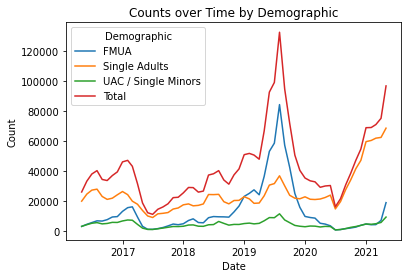

In [35]:
# this plot shows the predicted counts for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="Count",hue=CATEGORY)
plt.title("Counts over Time by "+CATEGORY)

Text(0.5, 0.98, '% Count over Time by Demographic')

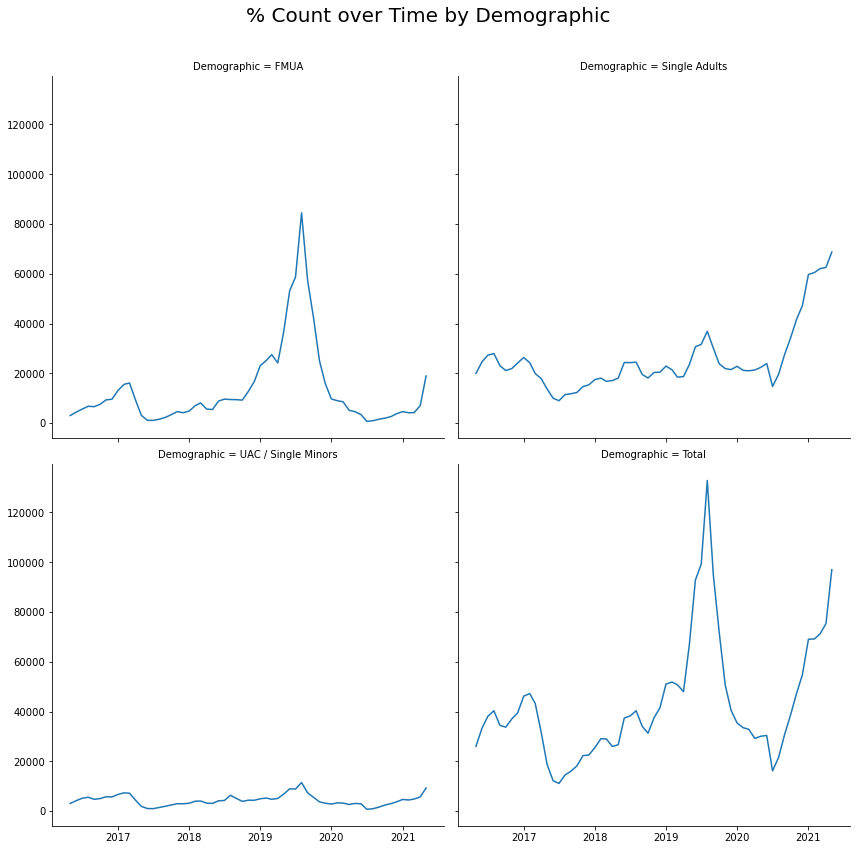

In [50]:
# these graphs are the same as the previous one, the predicted counts for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col=CATEGORY, col_wrap=col_wrap,height=6,aspect=1)
g.map_dataframe(sns.lineplot,x="Date",y="Count")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("% Count over Time by "+CATEGORY, size=20)

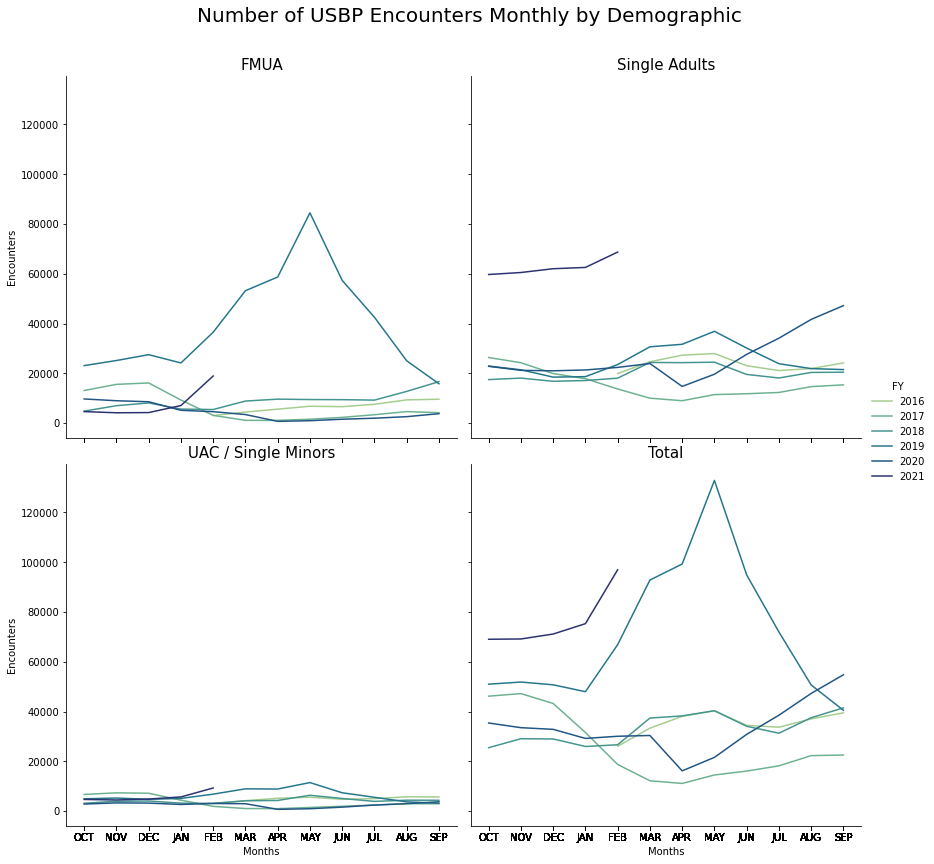

In [37]:
# These graphs show the month-to-month predicted counts for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
palette = sns.color_palette("crest", as_cmap=True)
g = sns.FacetGrid(graph_df, col=CATEGORY, col_wrap=col_wrap,height=6,aspect=1) 
g.map_dataframe(sns.lineplot,x="M",y="Count",hue="FY", palette=palette)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Number of USBP Encounters Monthly by '+CATEGORY, size=20)
g.set_titles(col_template="{col_name}", size=15)


g.set(xticks=graph_df.M)
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([inv_month_map[i] for i in xticks])

g.add_legend(title = "FY")
g.set_axis_labels("Months", "Encounters")

### Plots of the  Percent Change each Month

Text(0.5, 1.0, '% Change over Time by Demographic')

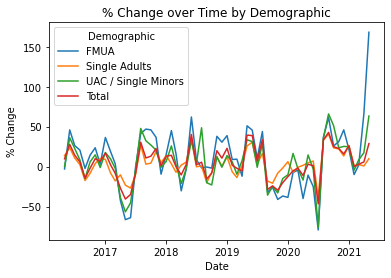

In [51]:
# this plot shows the percent change for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="% Change",hue=CATEGORY)
plt.title("% Change over Time by "+CATEGORY)

Text(0.5, 0.98, '% Change over Time by Demographic')

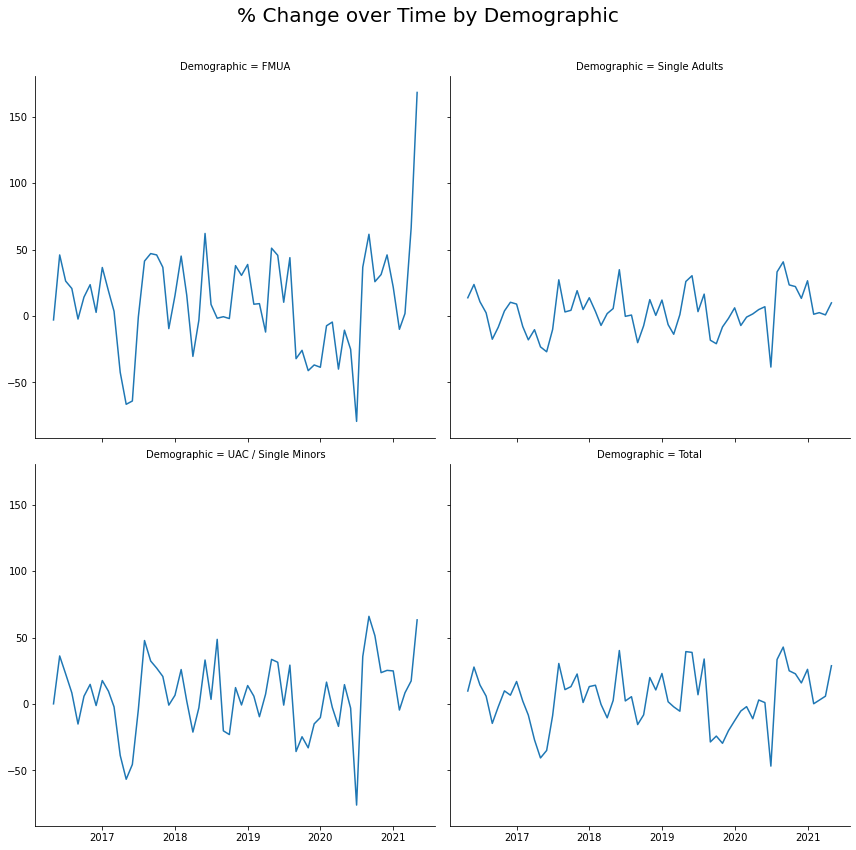

In [49]:
# these graphs are the same as the previous one, the percent change for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col=CATEGORY, col_wrap=col_wrap,height=6,aspect=1)
g.map_dataframe(sns.lineplot,x="Date",y="% Change")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("% Change over Time by "+CATEGORY, size=20)

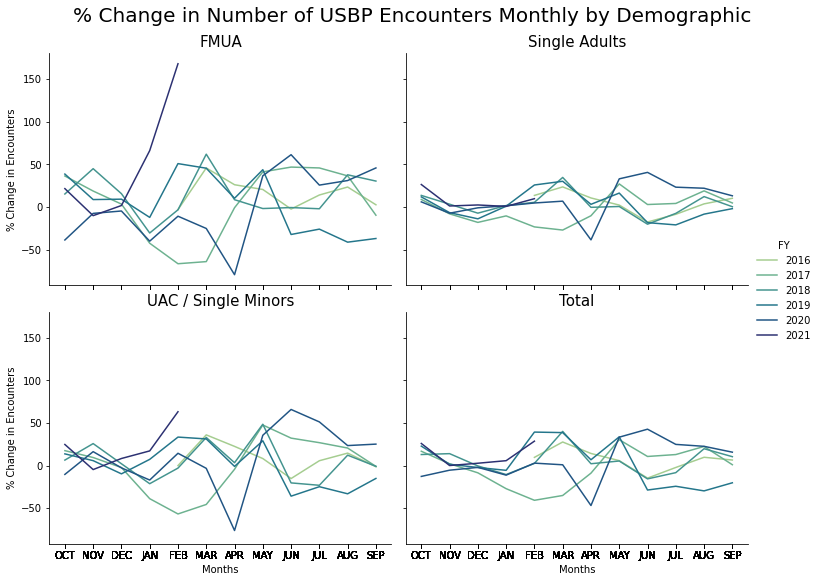

In [40]:
# These graphs show the month-to-month percent changes for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
palette = sns.color_palette("crest", as_cmap=True)
g = sns.FacetGrid(graph_df, col=CATEGORY, col_wrap=col_wrap,height=4,aspect=1.3)
g.map_dataframe(sns.lineplot,x="M",y="% Change",hue="FY",palette=palette,legend='full')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('% Change in Number of USBP Encounters Monthly by '+CATEGORY, size=20)
g.set_titles(col_template="{col_name}", size=15)


g.set(xticks=graph_df.M)
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([inv_month_map[i] for i in xticks])

g.add_legend(title = "FY")
g.set_axis_labels("Months", "% Change in Encounters")

### Different Plots of Error each Month

Text(0.5, 1.0, '%Error over Time by Demographic')

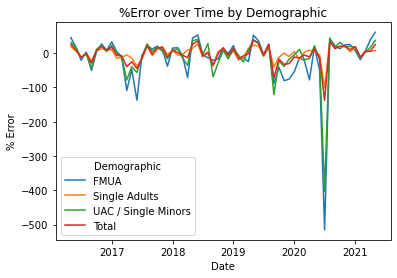

In [52]:
# this plot shows the error calculation for each demographic, year-to-year.
sns.lineplot(data=graph_df,x="Date",y="% Error",hue=CATEGORY)
plt.title("%Error over Time by "+CATEGORY)

Text(0.5, 0.98, '% Error over Time by Demographic')

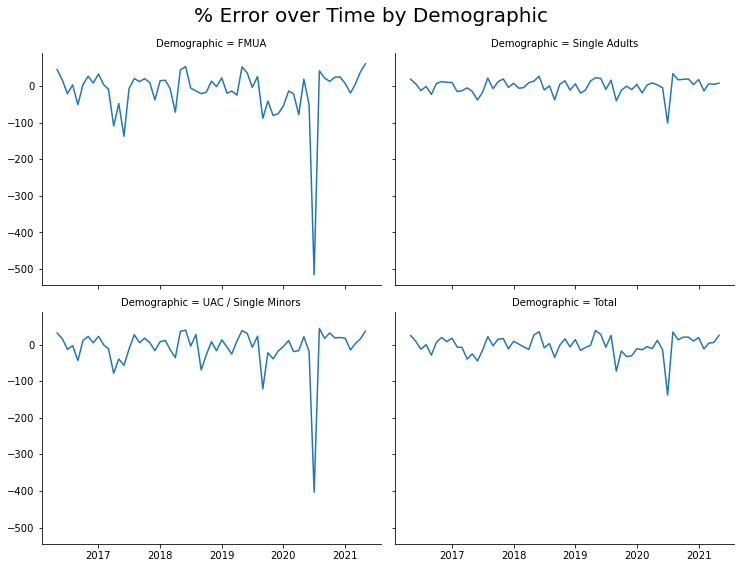

In [42]:
# these graphs are the same as the previous one, the error calculation for each month, but instead
# of all three demographics overlayed on one graph, they are separated into three different graphs
g = sns.FacetGrid(graph_df, col=CATEGORY, col_wrap=col_wrap,height=4,aspect=1.3)
g.map_dataframe(sns.lineplot,x="Date",y="% Error")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("% Error over Time by "+CATEGORY, size=20)

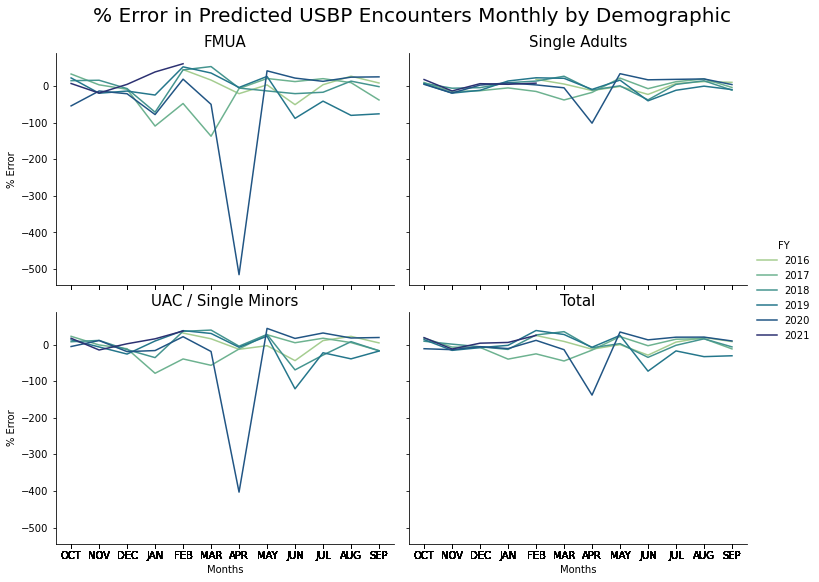

In [43]:
# These graphs show the month-to-month error calculation for the three demographics.  The darker
# lines or the more recent year's values (the darker the line, the more recent the data is).  The 
# month are represented on the x-axis by their fiscal year numerical value (OCT=1, NOV=2, etc.)
palette = sns.color_palette("crest", as_cmap=True)
g = sns.FacetGrid(graph_df, col=CATEGORY, col_wrap=col_wrap,height=4,aspect=1.3)
g.map_dataframe(sns.lineplot,x="M",y="% Error",hue="FY",palette=palette,legend='full')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('% Error in Predicted USBP Encounters Monthly by '+CATEGORY, size=20)
g.set_titles(col_template="{col_name}", size=15)


g.set(xticks=graph_df.M)
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([inv_month_map[i] for i in xticks])

g.add_legend(title = "FY")
g.set_axis_labels("Months", "% Error")

### Plots of the Actual and Predicted Counts by the selected Category and Year

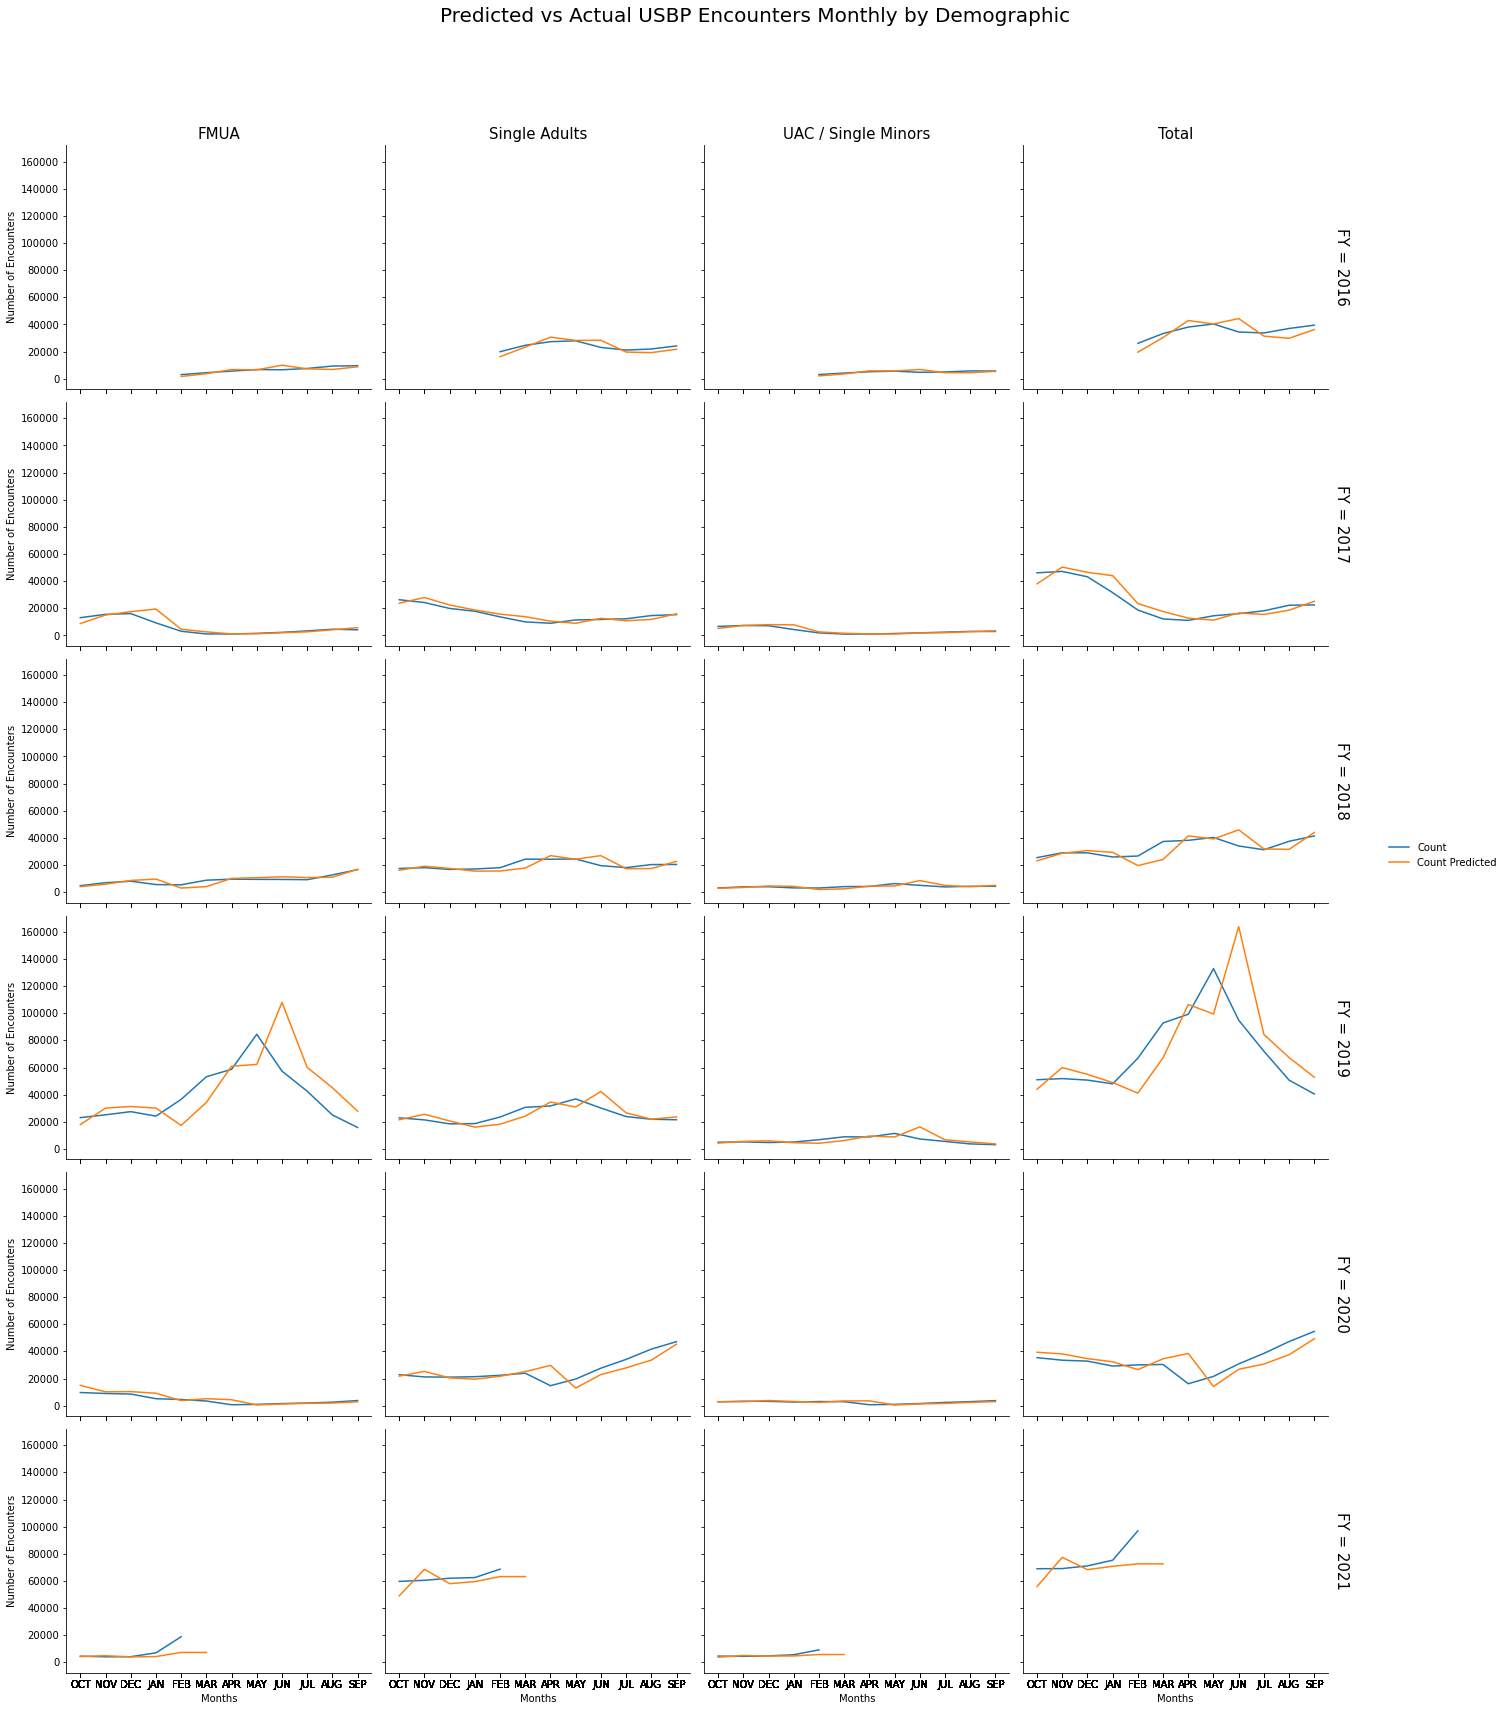

In [44]:
# the following graphs show the count in blue and the predicted count in orange.  We can see how
# good the predictions were based on how close the lines are together.  The x-axis has the months
# represented by their numerical value, and the y axis has the counts.  Each row of graphs
# represents a different fiscal year, and each column represents a different demographic.
melted_df = pd.melt(graph_df, id_vars=[CATEGORY,'FY','M'], value_vars=['Count', 'Count Predicted'])
g = sns.FacetGrid(melted_df, col=CATEGORY, row="FY",height=4,aspect=1.2,margin_titles=True)
g = g.map_dataframe(sns.lineplot,x="M",y="value",hue="variable")
g.add_legend()

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Predicted vs Actual USBP Encounters Monthly by '+CATEGORY, size=20)
g.set_titles(col_template="{col_name}", size=15)

g.set(xticks=graph_df.M)
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([inv_month_map[i] for i in xticks])

g.set_axis_labels("Months", "Number of Encounters")

### Main Report Graph

In [45]:
report_df  = graph_df.loc[graph_df['Date'] >= pd.to_datetime(
    str(most_recent_entry_date.month) + " " + str(most_recent_entry_date.year-1), format="%m %Y")]

melted_df = pd.melt(report_df, id_vars=[CATEGORY,'Date'], value_vars=['Count', 'Count Predicted'])

Exact numbers of the past year of counts and predictions

In [46]:
report_df.pivot(index="Date",columns=CATEGORY,values=["Count","Count Predicted"]).tail()

Count                                             \
Demographic     FMUA Single Adults    Total UAC / Single Minors   
Date                                                              
2021-02-01    4170.0       60516.0  69162.0              4476.0   
2021-03-01    4248.0       62041.0  71142.0              4853.0   
2021-04-01    7064.0       62554.0  75312.0              5694.0   
2021-05-01   18945.0       68732.0  96974.0              9297.0   
2021-06-01       NaN           NaN      NaN                 NaN   

            Count Predicted                                             
Demographic            FMUA Single Adults    Total UAC / Single Minors  
Date                                                                    
2021-02-01           4972.0       68609.0  77428.0              5135.0  
2021-03-01           4052.0       58035.0  68367.0              4741.0  
2021-04-01           4342.0       59547.0  70843.0              4792.0  
2021-05-01           7400.0       63273.0  72623.0              5844.0  
2021-06-01           7400.0       63273.0  72623.0              5844.0

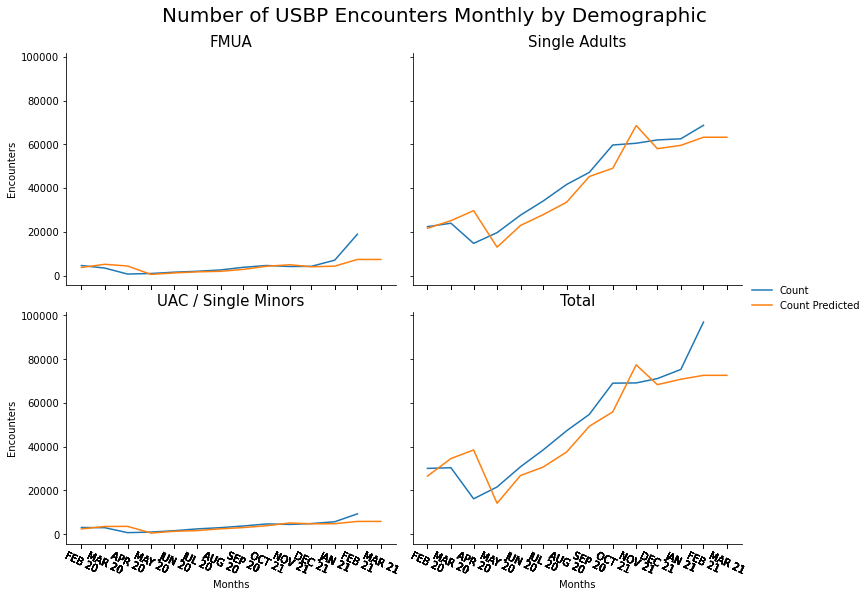

In [47]:
g = sns.FacetGrid(melted_df, col=CATEGORY, col_wrap=col_wrap,height=4,aspect=1.3)
g = g.map_dataframe(sns.lineplot,x="Date",y="value",hue="variable")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Number of USBP Encounters Monthly by '+CATEGORY, size=20)
g.set_titles(col_template="{col_name}", size=15)

values= melted_df["Date"].apply(lambda x: inv_month_map[x.month] + " " + str(x.year)[2:])
plt.xticks(melted_df["Date"],values)
plt.rcParams['font.weight'] = "regular"
[plt.setp(ax.get_xticklabels(), rotation=-25, fontweight = 0) for ax in g.axes.flat]

g.add_legend()
g.set_axis_labels("Months", "Encounters")